# Flat vs Full Tire - Kaggle Classification Problem
**source:** https://www.kaggle.com/datasets/rhammell/full-vs-flat-tire-images
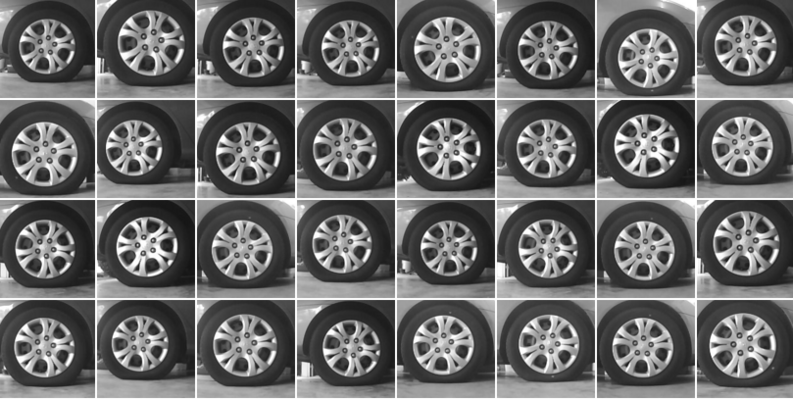

In [1]:
import os

# Math and tables
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Procesing the Tire Photos
import cv2

<div class="alert alert-block alert-info" >
<b>Wskazówka:</b> <p style="font-family: monospace">conda create --name computer_vision --clone ml </p>
</div>

# 1. Data
- Load data.
- Check what is the material we work with?
- Split into training and test sets.

#### Load data

In [2]:
# Paths to data
FLAT_TIRE_PATH = os.path.join('data', 'flat.class')
FULL_TIRE_PATH = os.path.join('data', 'full.class')
NO_TIRE_PATH = os.path.join('data', 'no-tire.class')

In [3]:
img_path = os.path.join(FLAT_TIRE_PATH, '00000.jpg')
img = cv2.imread(img_path)

#### Check what is the material we work with?

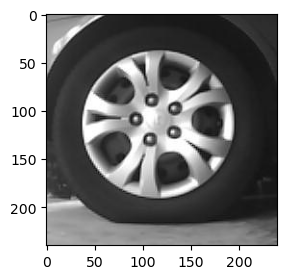

In [4]:
# Random Tire
plt.figure(figsize=(3, 3))
plt.imshow(img);

#### Conversion form .jpg to numpy arrays

In [5]:
def images_to_arrays(path) -> np.ndarray:
    """Converts images from given folder to an array of numpy arrays"""
    images = os.listdir(path)
    lst = [cv2.cvtColor(cv2.imread(os.path.join(path, img)), cv2.COLOR_BGR2GRAY) for img in images]
    return np.array(lst)

In [6]:
flat_tire_arrays = images_to_arrays(FLAT_TIRE_PATH)
full_tire_arrays = images_to_arrays(FULL_TIRE_PATH)
no_tire_arrays = images_to_arrays(NO_TIRE_PATH)

In [7]:
# Safty First!
for array in [flat_tire_arrays, full_tire_arrays, no_tire_arrays]:
    assert array.shape == (300, 240, 240)
    print(array.shape)

(300, 240, 240)
(300, 240, 240)
(300, 240, 240)


#### Split into training and test set

In [8]:
def train_val_test_split(train_size=0.7, val_size=0.15):
    """Returns train, validation and test datasets based on the tree datasets provided"""
    
    # Setup the thresholds
    test_size = 1 - train_size - val_size
    samples = full_tire_arrays.shape[0]
    
    train_threshold = int(300 * train_size)
    val_threshold = int(300 * val_size) + train_threshold
    test_threshold = int(300 * test_size) + val_threshold
    
    # Extract x_train, x_val and x_test from the original dataset
    x_train = np.concatenate(
        (flat_tire_arrays[:train_threshold], full_tire_arrays[:train_threshold], no_tire_arrays[:train_threshold])
    )
    
    x_val = np.concatenate(
        (flat_tire_arrays[train_threshold:val_threshold], full_tire_arrays[train_threshold:val_threshold], no_tire_arrays[train_threshold:val_threshold])
    )
    
    x_test = np.concatenate(
        (flat_tire_arrays[val_threshold:], full_tire_arrays[val_threshold:], no_tire_arrays[val_threshold:])
    )
    
    # Labels:
    # 0 - flat
    # 1 - full
    # 2 - no tire
    
    # Generate labels
    train_samples = int(samples * train_size)
    val_samples = int(samples * val_size)
    
    y_train = np.concatenate((np.full(train_samples, 0), np.full(train_samples, 1), np.full(train_samples, 2)))
    y_val = np.concatenate((np.full(val_samples, 0), np.full(val_samples, 1), np.full(val_samples, 2)))
    y_test= np.concatenate((np.full(val_samples, 0), np.full(val_samples, 1), np.full(val_samples, 2)))
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split()

In [10]:
for dataset in [x_train, x_val, x_test]:
    print(dataset.shape)

(630, 240, 240)
(135, 240, 240)
(135, 240, 240)


In [11]:
for label in [y_train, y_val, y_test]:
    print(label.shape)

(630,)
(135,)
(135,)


#### Normalization and Reshaping

In [12]:
from sklearn.preprocessing import normalize

def d3_to_d2(matrix):
    """Reshapes given matrix from 3-dimensional space to a 2-dimensional space."""
    num_samples = matrix.shape[0]
    return matrix.reshape(num_samples, matrix.shape[1] * matrix.shape[2])

In [13]:
x_train_prep = normalize(d3_to_d2(x_train))
x_val_prep = normalize(d3_to_d2(x_val))
x_test_prep = normalize(d3_to_d2(x_test))

# 2. Training
- Checking out different models.
- Using grid seach.
- Evaluating the model.

## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
forest = RandomForestClassifier(random_state=2023, oob_score=True)

forest.fit(x_train_prep, y_train)

RandomForestClassifier(oob_score=True, random_state=2023)

In [16]:
forest.oob_score_

0.9873015873015873

In [17]:
y_val_pred = forest.predict(x_val_prep)

from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_val_pred)

0.9851851851851852

#### Evaluation of Random Forest

In [18]:
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y_true, y_pred, class_labels=['flat','full','no-tire'], name=None) -> None:
    """Draws the confusion matrix as a nice heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    fig, ax = plt.subplots()
    sns.heatmap(data=cm, annot=True, cmap="crest", ax=ax,
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # Optional adding a title and saving the plot
    if name is not None:
        ax.set_title(name, fontsize=14)
        fig.savefig(f"{name.replace(' ','_')}.jpg",dpi=300)

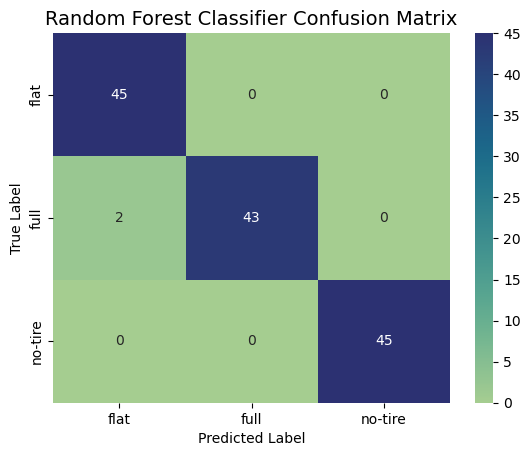

In [19]:
draw_confusion_matrix(y_val, y_val_pred, name='Random Forest Classifier Confusion Matrix')

In [20]:
accuracy_score(y_val, y_val_pred)

0.9851851851851852

#### Tires causing confusion...
The **Random Forest** is dealig pretty good on the validation dataset. It has a high accuracy score (0.98). In an ideal situation all prediction would lay on the diagonal (marked in blue). However, this model confuses two full tires with flat tires (in the middle row on the left side). Let's examine this two samples! 

In [21]:
indices = np.where((y_val_pred == y_val) == False)[0]  # Find tires indices which were confused
indices

array([84, 86], dtype=int64)

(-0.5, 239.5, 239.5, -0.5)

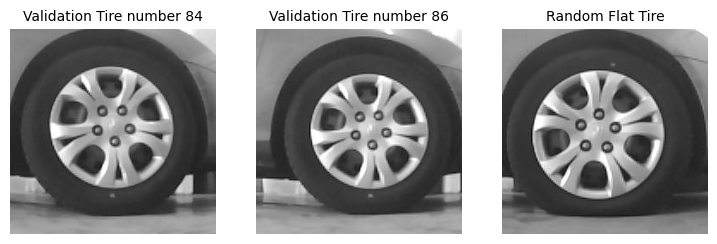

In [22]:
# Visualisation of the confusied tires
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(2):
    ax[i].set_title(f"Validation Tire number {indices[i]}", fontsize=10)
    ax[i].imshow(x_val[indices[i]], cmap='gray')
    ax[i].axis('off')

ax[2].imshow(x_val[5], cmap='gray')  # Random flat tire for comparison
ax[2].set_title("Random Flat Tire", fontsize=10)
ax[2].axis('off')

As we can see, this two tires aren't obviously flat! For comparison I showed a random selected flat tire.

## Support Vector Machines (SVMs)
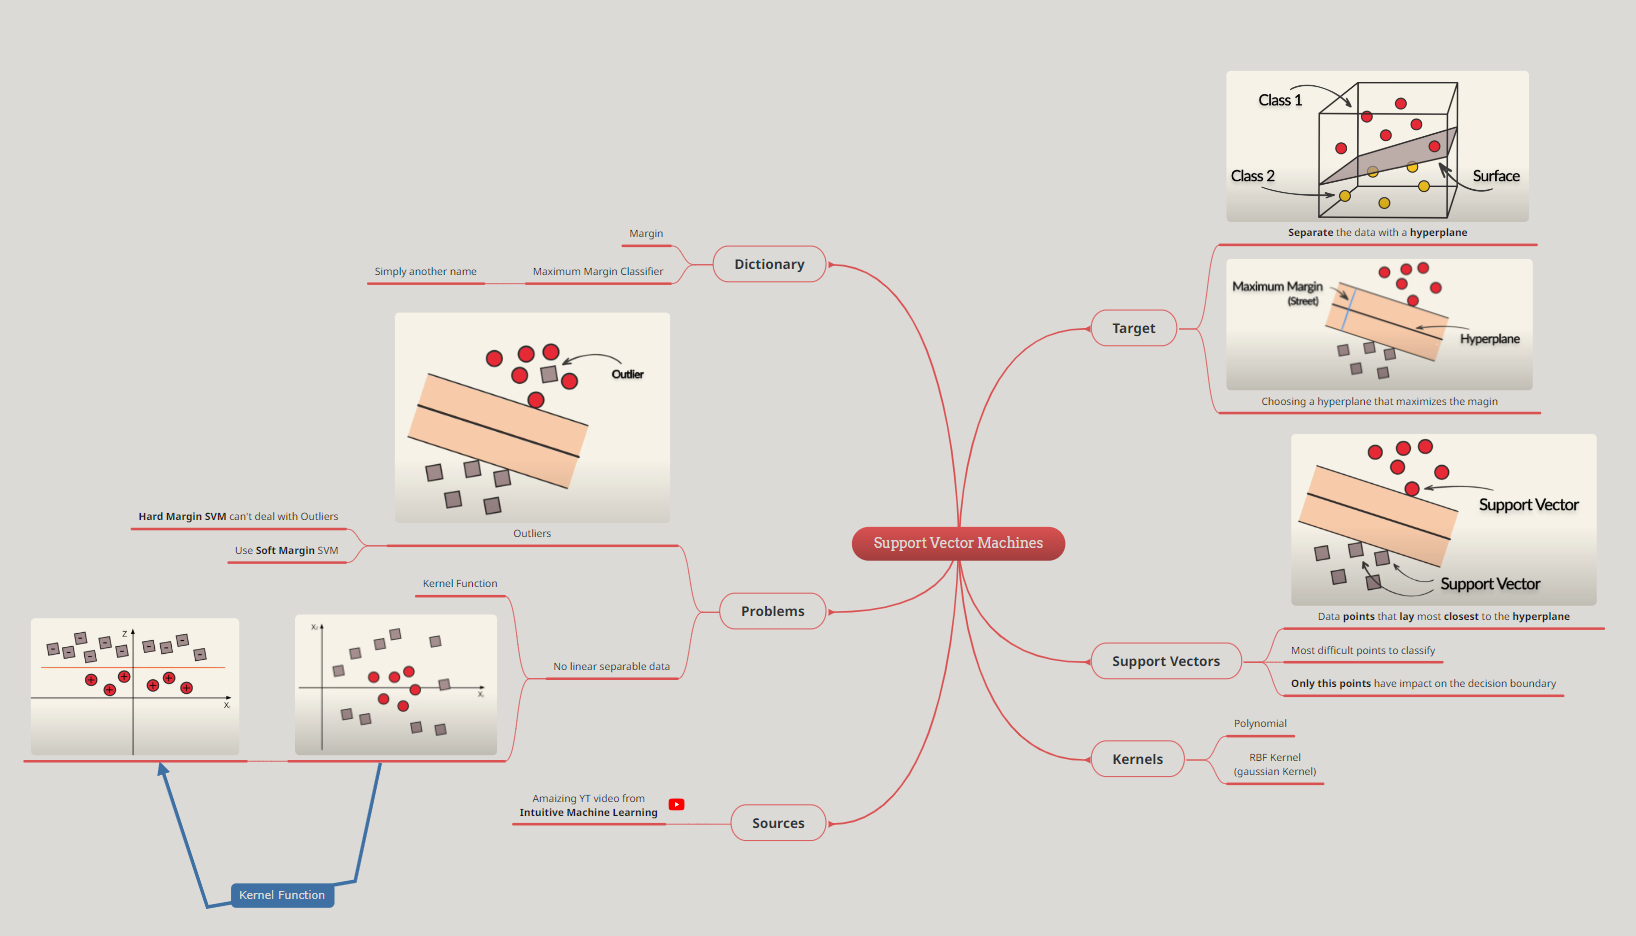

In [23]:
from sklearn.svm import SVC

svc = SVC(gamma='auto', random_state=2023)

svc.fit(x_train_prep, y_train)

SVC(gamma='auto', random_state=2023)

In [24]:
y_val_pred = svc.predict(x_val_prep)

In [25]:
accuracy_score(y_val, y_val_pred)

0.9555555555555556

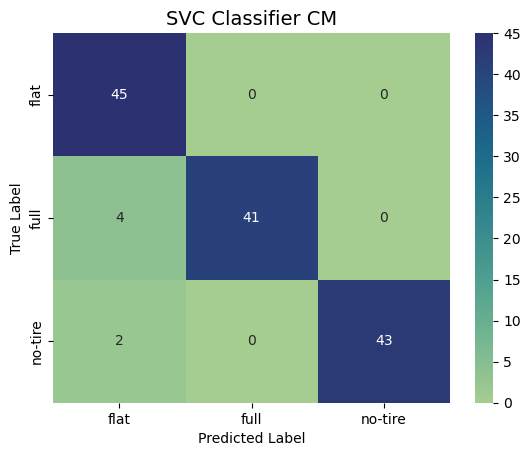

In [26]:
draw_confusion_matrix(y_val, y_val_pred, name='SVC Classifier CM')

#### Grid search

In [27]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 2, 0.5]
}

svc_grid = GridSearchCV(estimator=svc,
                        param_grid=param_grid,
                        cv=3,
                        verbose=2)

In [28]:
svc_grid.fit(x_train_prep, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................C=1, kernel=linear; total time=   6.6s
[CV] END .................................C=1, kernel=linear; total time=   6.0s
[CV] END .................................C=1, kernel=linear; total time=   6.0s
[CV] END ...................................C=1, kernel=poly; total time=  14.0s
[CV] END ...................................C=1, kernel=poly; total time=  13.4s
[CV] END ...................................C=1, kernel=poly; total time=  15.1s
[CV] END ....................................C=1, kernel=rbf; total time=  25.0s
[CV] END ....................................C=1, kernel=rbf; total time=  14.4s
[CV] END ....................................C=1, kernel=rbf; total time=  14.2s
[CV] END .................................C=2, kernel=linear; total time=   5.6s
[CV] END .................................C=2, kernel=linear; total time=   5.6s
[CV] END .................................C=2, ke

GridSearchCV(cv=3, estimator=SVC(gamma='auto', random_state=2023),
             param_grid={'C': [1, 2, 0.5], 'kernel': ['linear', 'poly', 'rbf']},
             verbose=2)

In [29]:
svc_grid.best_estimator_;

In [30]:
svc_grid.best_score_

0.9238095238095237

## K-Nearest Neighbours

In [49]:
from sklearn.neighbors import KNeighborsClassifier

k_param_grid = {
    'n_neighbors': [15, 20, 30, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'cityblock']
}

knn_clf = KNeighborsClassifier()

k_grid = GridSearchCV(estimator=knn_clf,
                      param_grid=k_param_grid,
                      cv=3, verbose=2)

k_grid.fit(x_train_prep, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...................metric=minkowski, n_neighbors=15; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=15; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=15; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=20; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=20; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=20; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=30; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=30; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=30; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=40; total time=   0.3s
[CV] END ...................metric=minkowski, n_neighbors=40; total time=   0.4s
[CV] END ...................metric=minkowski, n_n

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'cityblock'],
                         'n_neighbors': [15, 20, 30, 40]},
             verbose=2)

In [51]:
k_grid.best_estimator_

KNeighborsClassifier(metric='cityblock', n_neighbors=20)

In [52]:
k_grid.best_score_

0.7507936507936508

K-Nearest Neighbours achieved rather poor results.

#### Final Test

In [32]:
# Uncomment to run the final test :-)
# x_test_respahed = x_test.reshape(180, -1)
# forest.score(x_test_respahed, y_test)

# Achieved Results
- Random Forest - 0.982
- K-Nearest Neighbours (grid search) - 0.75
- SVM (grid search) - 0.923

In [33]:
# Achieved Results for Random Forest
# 0.9825396825396825 - At start, almost no improvments
# 0.9873015873015873 - After normalization